# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 3 — Frontier LLMs via OpenRouter API
### Zero-Shot Dialogue Summarization with GPT, Claude, Gemini, and More
---

This notebook implements **Experiment 3** for the capstone project:

**Goal:**  
Evaluate frontier large language models on dialogue summarization using the OpenRouter API:

- **OpenAI GPT-5 family** (nano, mini, full)
- **OpenAI open-weight models** (20B, 120B)
- **Google Gemini 2.5 Flash**
- **Anthropic Claude 4.5 Sonnet**
- **Qwen 2.5 72B**

Unlike Experiments 1 and 2 which fine-tune models locally, this experiment uses
**zero-shot prompting** — no training, just inference via API calls.

This establishes the **upper-bound performance baseline** for the project.

**What This Notebook Covers:**
1. Configuration and API setup
2. Loading SAMSum test data
3. Prompt construction for zero-shot summarization
4. Running API calls (with caching and retry logic)
5. ROUGE evaluation on **test set**
6. Latency analysis
7. Qualitative examples and model comparison

**Note:** This notebook parallels the structure of `02_experiment1_bert_gpt2-revised.ipynb`
and `03_experiment2_bart_t5-revised.ipynb` for consistency across experiments.

## 1. Environment Setup

In [39]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
import numpy as np
import pandas as pd
import time
import requests
import json
import hashlib
from pathlib import Path
import warnings

# Mute common warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Project root
PROJECT_ROOT = Path("..").resolve()

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f"Project root: {PROJECT_ROOT}")
print(f"Random seed: {SEED}")

Project root: /home/timnevits/projects/flatiron-language-models-for-ai
Random seed: 42


## 2. Configuration

All hyperparameters and paths in one place for easy modification.

**Important:** 
- Set `RUN_API_CALLS` to `False` to load cached results instead of making new API calls
- Set `EVALUATION_MODE` to `"full"` for final results on the entire test set

In [40]:
# =============================================================================
# API CALL FLAGS
# =============================================================================

# Master switch: Set False to load ALL results from cache (no API calls)
RUN_API_CALLS = True

# Per-model control: Set individual models to False to skip them
# Only matters if RUN_API_CALLS = True
MODELS_TO_RUN = {
    "gpt5_mini":                False,
    "gemini_25_flash":          False,
    "claude_45_haiku":          False,
    "qwen25_72b":               False,
    "kimi_k2":                  False,
}

# =============================================================================
# EVALUATION MODE
# =============================================================================

# "test": Use a small sample (fast, cheap) for development
# "full": Use entire test set (slow, expensive) for final results
EVALUATION_MODE = "test"  # Change to "full" for final evaluation

# How many samples to use in "test" mode (ignored in "full" mode)
TEST_MODE_SAMPLES = 10

# =============================================================================
# GENERATION PARAMETERS
# =============================================================================
MAX_OUTPUT_TOKENS = 128   # Max tokens for model responses
TEMPERATURE = 0.2         # Low temperature for consistent summaries

# =============================================================================
# MODEL DEFINITIONS
# =============================================================================
OPENROUTER_MODELS = {
    # OpenAI 
    "gpt5_mini":       "openai/gpt-5-mini",

    # Google Gemini
    "gemini_25_flash": "google/gemini-2.5-flash",

    # Anthropic Claude
    "claude_45_haiku": "anthropic/claude-haiku-4.5",

    # Qwen
    "qwen25_72b":      "qwen/qwen-2.5-72b-instruct",

    # Moonshot Kimi K2
    "kimi_k2":         "moonshotai/kimi-k2-0905",
}

# =============================================================================
# PATHS
# =============================================================================
OUTPUT_DIR = PROJECT_ROOT / "models" / "api-frontier"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CACHE_DIR = OUTPUT_DIR / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

TEST_RESULTS_PATH = OUTPUT_DIR / "test_results.csv"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

print("Configuration loaded.")
print(f"  Evaluation mode: {EVALUATION_MODE}")
if EVALUATION_MODE == "test":
    print(f"  Sample size: {TEST_MODE_SAMPLES} examples")
else:
    print(f"  Sample size: FULL test set")
print(f"  Models configured: {len(OPENROUTER_MODELS)}")
print(f"  Output directory: {OUTPUT_DIR}")

Configuration loaded.
  Evaluation mode: test
  Sample size: 10 examples
  Models configured: 5
  Output directory: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier


## 3. OpenRouter API Client

All API interaction code is defined here inline for transparency and reproducibility.

In [41]:
# =============================================================================
# OPENROUTER API CLIENT
# =============================================================================

# Load API key from environment variable
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

if OPENROUTER_API_KEY is None:
    print("⚠️  WARNING: OPENROUTER_API_KEY environment variable not set.")
    print("   Set it with: export OPENROUTER_API_KEY='your-key-here'")
    print("   API calls will fail until this is set.")
else:
    print(f"✓ OpenRouter API key loaded (ends with ...{OPENROUTER_API_KEY[-4:]})")

# API configuration
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1/chat/completions"
REQUEST_TIMEOUT = (10, 60)  # (connect_timeout, read_timeout) in seconds
MAX_RETRIES = 3

# Unique error prefix for identifying API failures in results
ERROR_PREFIX = "[__OPENROUTER_ERROR__:"


def _get_api_headers():
    """Get headers for API requests. Raises if key not set."""
    if OPENROUTER_API_KEY is None:
        raise RuntimeError(
            "OPENROUTER_API_KEY environment variable not set.\n"
            "Set it with: export OPENROUTER_API_KEY='your-key-here'"
        )
    return {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }


def _get_reasoning_config(model: str) -> dict:
    """
    Return reasoning config for models that support it.
    Uses "minimal" effort to reduce latency/cost.
    """
    base = model.split("/")[-1].lower()
    
    # Models that support reasoning
    reasoning_prefixes = ("gpt-5-mini")
    
    for prefix in reasoning_prefixes:
        if base.startswith(prefix):
            return {"effort": "minimal", "exclude": True}
    
    return {"effort": "none", "exclude": True}


def call_openrouter_api(
    model: str,
    prompt: str,
    max_tokens: int = 128,
    temperature: float = 0.2,
):
    """
    Call an LLM via OpenRouter API.
    
    Parameters
    ----------
    model : str
        OpenRouter model identifier (e.g., "openai/gpt-5-nano")
    prompt : str
        The user prompt to send
    max_tokens : int
        Maximum tokens in response
    temperature : float
        Sampling temperature (lower = more deterministic)
    
    Returns
    -------
    tuple
        (response_text, latency_seconds)
        On error, response_text starts with ERROR_PREFIX
    """
    headers = _get_api_headers()
    
    payload = {
        "model": model,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "messages": [
            {
                "role": "system",
                "content": "You summarize chat conversations accurately and concisely."
            },
            {
                "role": "user",
                "content": prompt
            },
        ],
    }
    
    # Add reasoning config if applicable
    reasoning_config = _get_reasoning_config(model)
    if reasoning_config:
        payload["reasoning"] = reasoning_config
    
    last_error = None
    
    for attempt in range(1, MAX_RETRIES + 1):
        t0 = time.time()
        
        try:
            response = requests.post(
                OPENROUTER_BASE_URL,
                headers=headers,
                json=payload,
                timeout=REQUEST_TIMEOUT,
            )
            t1 = time.time()
            
            # Small delay for rate limiting
            time.sleep(0.05)
            
            # Parse JSON response
            try:
                data = response.json()
            except Exception as json_err:
                raise RuntimeError(f"Failed to parse JSON: {json_err}")
            
            # Check HTTP status
            if response.status_code != 200:
                error_msg = data.get("error", {}).get("message", response.text) if data else response.text
                raise RuntimeError(f"API error {response.status_code}: {error_msg}")
            
            # Extract response text
            try:
                if not data:
                    raise ValueError("Empty response")
                
                choices = data.get("choices")
                if not choices or len(choices) == 0:
                    raise ValueError(f"No choices in response: {data}")
                
                message = choices[0].get("message")
                if not message:
                    raise ValueError(f"No message in choice: {choices[0]}")
                
                text = message.get("content", "")
                
                if not isinstance(text, str):
                    text = str(text) if text is not None else ""
                
                if text.strip() == "":
                    text = f"{ERROR_PREFIX} EMPTY_RESPONSE]"
                    
            except (KeyError, IndexError, TypeError, ValueError) as extract_err:
                text = f"{ERROR_PREFIX} MALFORMED_RESPONSE: {extract_err}]"
            
            latency = t1 - t0
            return text, latency
            
        except (requests.exceptions.Timeout, requests.exceptions.ConnectionError) as e:
            last_error = e
            if attempt < MAX_RETRIES:
                # Exponential backoff
                time.sleep(0.5 * (2 ** (attempt - 1)))
            else:
                break
                
        except RuntimeError:
            raise
    
    # All retries failed
    return f"{ERROR_PREFIX} Request failed after {MAX_RETRIES} attempts: {last_error}]", float('nan')


print("\nAPI client functions defined.")

✓ OpenRouter API key loaded (ends with ...5990)

API client functions defined.


## 4. Load SAMSum Test Data

In [42]:
from datasets import load_dataset

# Load SAMSum dataset
print("Loading SAMSum dataset...")
ds = load_dataset("knkarthick/samsum")

train_df = ds["train"].to_pandas()
val_df = ds["validation"].to_pandas()
test_df = ds["test"].to_pandas()

print(f"\nDataset sizes:")
print(f"  Train:      {len(train_df):,} examples")
print(f"  Validation: {len(val_df):,} examples")
print(f"  Test:       {len(test_df):,} examples")

Loading SAMSum dataset...

Dataset sizes:
  Train:      14,731 examples
  Validation: 818 examples
  Test:       819 examples


In [43]:
# Quick peek at the data
print("Sample dialogue:")
print("-" * 40)
print(test_df.iloc[0]["dialogue"][:300], "...")
print()
print("Sample summary:")
print("-" * 40)
print(test_df.iloc[0]["summary"])

Sample dialogue:
----------------------------------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
H ...

Sample summary:
----------------------------------------
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## 5. Prepare Evaluation Sample

We use a consistent sample for reproducibility. The sample is cached to ensure
the same examples are used across runs.

In [44]:
def get_evaluation_sample(test_df, n_samples, seed, cache_dir):
    """
    Get evaluation sample with caching for reproducibility.
    
    Saves metadata to ensure we're using consistent samples across runs.
    """
    sample_path = cache_dir / "evaluation_sample.csv"
    metadata_path = cache_dir / "evaluation_sample_metadata.json"
    
    # Create fingerprint of source data
    source_len = len(test_df)
    dialogue_lengths = test_df['dialogue'].str.len().tolist()
    
    fingerprint_data = {
        "length": source_len,
        "dialogue_length_sum": sum(dialogue_lengths),
        "first_dialogue": test_df['dialogue'].iloc[0][:200] if source_len > 0 else "",
        "last_dialogue": test_df['dialogue'].iloc[-1][:200] if source_len > 0 else "",
    }
    
    data_fingerprint = hashlib.md5(
        json.dumps(fingerprint_data, sort_keys=True).encode()
    ).hexdigest()[:16]
    
    # Check for valid cached sample
    if sample_path.exists() and metadata_path.exists():
        try:
            with open(metadata_path, 'r') as f:
                saved_meta = json.load(f)
            
            if (saved_meta.get('n_samples') == n_samples and
                saved_meta.get('seed') == seed and
                saved_meta.get('data_hash') == data_fingerprint):
                
                existing_sample = pd.read_csv(sample_path)
                
                if len(existing_sample) == n_samples:
                    print(f"✓ Loaded cached sample of {len(existing_sample)} examples")
                    print(f"  (seed={seed}, hash={data_fingerprint[:8]}...)")
                    return existing_sample
                    
        except (json.JSONDecodeError, KeyError):
            pass
    
    # Create new sample
    if n_samples >= len(test_df):
        sample = test_df.copy().reset_index(drop=True)
        print(f"Using full test set: {len(sample)} examples")
    else:
        sample = test_df.sample(n=n_samples, random_state=seed).reset_index(drop=True)
        print(f"Created sample of {len(sample)} examples (seed={seed})")
    
    # Save sample and metadata
    sample.to_csv(sample_path, index=False)
    
    metadata = {
        'n_samples': n_samples,
        'seed': seed,
        'data_hash': data_fingerprint,
        'source_len': source_len,
        'created_at': pd.Timestamp.now().isoformat(),
    }
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved to cache: {sample_path.name}")
    
    return sample


# Determine sample size based on evaluation mode
if EVALUATION_MODE == "full":
    N_SAMPLES = len(test_df)
    print(f"\n📊 FULL EVALUATION MODE: Using ALL {N_SAMPLES} test examples")
    print(f"   ⚠️  This will take a while and cost more in API calls!\n")
else:
    N_SAMPLES = TEST_MODE_SAMPLES
    print(f"\n🧪 TEST MODE: Using {N_SAMPLES} examples (for development)")
    print(f"   Change EVALUATION_MODE to 'full' for final results.\n")

# Get the evaluation sample
eval_df = get_evaluation_sample(test_df, N_SAMPLES, SEED, CACHE_DIR)

print(f"\nEvaluation sample: {len(eval_df)} examples")
eval_df.head()


🧪 TEST MODE: Using 10 examples (for development)
   Change EVALUATION_MODE to 'full' for final results.

✓ Loaded cached sample of 10 examples
  (seed=42, hash=f67f1de0...)

Evaluation sample: 10 examples


,id,dialogue,summary
0,13820547,Olafur: are we doing anything for New Year's E...,"Nathalie, Olafur and Zoe are planning the New ..."
1,13682134,Javier: Hey do you know any tattoo parlors ove...,Javier was initially eager to have a tatoo don...
2,13611508,"Martha: Hey, can I ask you a question?\nOpheli...",Martha likes Ophelia's lenses and wants to buy...
3,13829744,"Miranda: Hi S, could we cancel tomorrow's meet...",Miranda can't make her meeting with Stephanie ...
4,13864860,Sam: Where are you?\nKate: downstairs\nSam: al...,Kate and Jeff are downstairs in a room next to...


## 6. Prompt Construction

We use a consistent zero-shot prompt across all models.

In [45]:
def build_summarization_prompt(dialogue: str) -> str:
    """
    Build a zero-shot summarization prompt for frontier LLMs.
    
    The prompt is designed to produce concise summaries similar
    to the SAMSum reference summaries (typically 15-30 words).
    """
    return (
        "Summarize the following conversation in 1-2 sentences. "
        "Keep it brief — aim for 15-30 words. "
        "Focus on the main point, decisions, requests, or outcomes. "
        "Ignore small talk and do not add details that aren't supported by the text.\n\n"
        "DIALOGUE:\n"
        "-----\n"
        f"{dialogue}\n"
        "-----\n\n"
        "SUMMARY:"
    )


# Test the prompt
print("Example prompt:")
print("=" * 60)
example_prompt = build_summarization_prompt(eval_df['dialogue'].iloc[0])
print(example_prompt[:500] + "..." if len(example_prompt) > 500 else example_prompt)

Example prompt:
Summarize the following conversation in 1-2 sentences. Keep it brief — aim for 15-30 words. Focus on the main point, decisions, requests, or outcomes. Ignore small talk and do not add details that aren't supported by the text.

DIALOGUE:
-----
Olafur: are we doing anything for New Year's Eve?
Nathalie: I was thinking about something classy, like opera or sth like that
Zoe: how much does it cost?
Olafur: opera is not for me
Nathalie: so what do you propose?
Nathalie: it's 100$ 
Olafur: I was thin...


## 7. Run API Calls

Generate summaries for each model. Results are cached per-model for efficiency.

In [46]:
from tqdm.auto import tqdm


def get_model_cache_path(model_label: str) -> Path:
    """Get the cache path for a model's results."""
    return CACHE_DIR / f"{model_label}_predictions.csv"


def load_cached_predictions(model_label: str) -> pd.DataFrame | None:
    """Load cached predictions for a model if they exist."""
    path = get_model_cache_path(model_label)
    if path.exists():
        return pd.read_csv(path)
    return None


def run_model_predictions(model_label: str, model_id: str, eval_df: pd.DataFrame) -> pd.DataFrame:
    """
    Run API calls for a single model and return results DataFrame.
    
    Returns DataFrame with columns:
    - dialogue
    - reference_summary (human)
    - model_summary (prediction)
    - latency_seconds
    """
    rows = []
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=model_label):
        dialogue = row["dialogue"]
        reference = row["summary"]
        prompt = build_summarization_prompt(dialogue)
        
        try:
            prediction, latency = call_openrouter_api(
                model=model_id,
                prompt=prompt,
                max_tokens=MAX_OUTPUT_TOKENS,
                temperature=TEMPERATURE,
            )
        except Exception as e:
            prediction = f"{ERROR_PREFIX} {e}]"
            latency = np.nan
        
        rows.append({
            "dialogue": dialogue,
            "reference_summary": reference,
            "model_summary": prediction,
            "latency_seconds": latency,
        })
    
    return pd.DataFrame(rows)


print("Helper functions defined.")

Helper functions defined.


In [47]:
print("\n" + "=" * 70)
print("RUNNING MODEL EVALUATIONS")
print("=" * 70)

results_by_model = {}
models_run = []
models_loaded = []
models_skipped = []

for label, model_id in OPENROUTER_MODELS.items():
    cache_path = get_model_cache_path(label)
    
    # Check if we should run this model
    should_run = RUN_API_CALLS and MODELS_TO_RUN.get(label, True)
    
    if should_run:
        if cache_path.exists():
            print(f"\n{label}: Cache exists, re-running (RUN_API_CALLS=True)")
        else:
            print(f"\n{label}: Running API calls...")
        
        # Run predictions
        df_results = run_model_predictions(label, model_id, eval_df)
        
        # Cache results
        df_results.to_csv(cache_path, index=False)
        print(f"  ✓ Saved {len(df_results)} results to {cache_path.name}")
        
        results_by_model[label] = df_results
        models_run.append(label)
        
    else:
        # Try to load from cache
        cached = load_cached_predictions(label)
        
        if cached is not None:
            results_by_model[label] = cached
            models_loaded.append(label)
            print(f"{label}: Loaded {len(cached)} cached results")
        else:
            models_skipped.append(label)
            print(f"{label}: No cache found (skipping)")

# Summary
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"  Models run (API calls):  {len(models_run)} - {models_run}")
print(f"  Models loaded (cache):   {len(models_loaded)} - {models_loaded}")
print(f"  Models skipped:          {len(models_skipped)} - {models_skipped}")
print(f"  Total models available:  {len(results_by_model)}")


RUNNING MODEL EVALUATIONS
gpt5_mini: Loaded 10 cached results
gemini_25_flash: Loaded 10 cached results
claude_45_haiku: Loaded 10 cached results
qwen25_72b: Loaded 10 cached results
kimi_k2: Loaded 10 cached results

SUMMARY
  Models run (API calls):  0 - []
  Models loaded (cache):   5 - ['gpt5_mini', 'gemini_25_flash', 'claude_45_haiku', 'qwen25_72b', 'kimi_k2']
  Models skipped:          0 - []
  Total models available:  5


## 8. ROUGE Evaluation

Compute ROUGE scores using the same methodology as Experiments 1 and 2.

In [48]:
import evaluate

# Load ROUGE metric
rouge_metric = evaluate.load("rouge")


def compute_rouge(predictions: list, references: list) -> dict:
    """
    Compute ROUGE scores for predictions vs references.
    
    Uses the same configuration as Experiments 1 and 2 for consistency.
    
    Returns dict with rouge1, rouge2, rougeL, rougeLsum (as floats 0-1).
    """
    # Clean inputs
    def clean_text(text):
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return ""
        return str(text).strip()
    
    predictions = [clean_text(p) for p in predictions]
    references = [clean_text(r) for r in references]
    
    result = rouge_metric.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True,  # Same as experiments 1 & 2
    )
    
    return result


print("ROUGE evaluation function defined.")

ROUGE evaluation function defined.


In [49]:
print("\n" + "=" * 70)
print("ROUGE EVALUATION")
print("=" * 70)

rouge_scores = {}
sample_counts = {}

for label, df in results_by_model.items():
    # Filter out API errors
    valid_mask = ~df["model_summary"].str.startswith(ERROR_PREFIX)
    valid_df = df[valid_mask]
    
    if len(valid_df) == 0:
        print(f"❌ {label}: No valid responses (all failed)")
        continue
    
    error_count = len(df) - len(valid_df)
    if error_count > 0:
        error_pct = error_count / len(df) * 100
        print(f"⚠️  {label}: {error_count} errors ({error_pct:.1f}%), evaluating {len(valid_df)} responses")
    
    # Compute ROUGE
    scores = compute_rouge(
        predictions=valid_df["model_summary"].tolist(),
        references=valid_df["reference_summary"].tolist(),
    )
    
    rouge_scores[label] = scores
    sample_counts[label] = len(valid_df)

# Create summary DataFrame
if rouge_scores:
    rouge_df = pd.DataFrame.from_dict(rouge_scores, orient="index")
    rouge_df.index.name = "model"
    rouge_df["n_samples"] = pd.Series(sample_counts)
    rouge_df = rouge_df.sort_values(by="rougeL", ascending=False)
    
    # Check for comparability
    min_samples = rouge_df["n_samples"].min()
    max_samples = rouge_df["n_samples"].max()
    
    if min_samples != max_samples:
        print("\n" + "=" * 60)
        print("⚠️  COMPARABILITY WARNING")
        print("=" * 60)
        print(f"Models evaluated on different sample sizes ({min_samples} to {max_samples})")
        print("ROUGE scores may not be directly comparable.")
        print("=" * 60)
    
    print("\nROUGE Scores (sorted by ROUGE-L):")
    display(rouge_df)
    
else:
    rouge_df = None
    print("No ROUGE scores to display.")


ROUGE EVALUATION

ROUGE Scores (sorted by ROUGE-L):


,rouge1,rouge2,rougeL,rougeLsum,n_samples
model,,,,,
kimi_k2,0.433138,0.102342,0.345211,0.345084,10
qwen25_72b,0.458951,0.106002,0.315847,0.316831,10
gemini_25_flash,0.458116,0.135972,0.315497,0.316654,10
claude_45_haiku,0.427340,0.134305,0.293141,0.294403,10
gpt5_mini,0.409726,0.117771,0.283475,0.281346,10


## 9. Latency Analysis

In [50]:
print("\n" + "=" * 70)
print("LATENCY ANALYSIS")
print("=" * 70)

latency_stats = {}

for label, df in results_by_model.items():
    latencies = df["latency_seconds"].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(latencies) == 0:
        continue
    
    stats = latencies.describe(percentiles=[0.5, 0.9, 0.95])
    latency_stats[label] = stats

if latency_stats:
    latency_df = pd.DataFrame(latency_stats).T
    latency_df.index.name = "model"
    
    # Rename columns for clarity
    latency_df = latency_df.rename(columns={
        "50%": "p50",
        "90%": "p90",
        "95%": "p95",
    })
    
    # Sort by mean latency
    latency_df = latency_df.sort_values(by="mean", ascending=True)
    
    print("\nLatency Statistics (seconds, sorted by mean):")
    display(latency_df[["count", "mean", "std", "min", "p50", "p90", "p95", "max"]])
    
else:
    latency_df = None
    print("No latency data to display.")


LATENCY ANALYSIS

Latency Statistics (seconds, sorted by mean):


,count,mean,std,min,p50,p90,p95,max
model,,,,,,,,
gemini_25_flash,10.0,0.698381,0.322236,0.511316,0.597121,0.819191,1.204699,1.590208
gpt5_mini,10.0,1.210712,0.230898,0.913929,1.113923,1.524753,1.589381,1.654009
claude_45_haiku,10.0,1.493662,0.182003,1.301841,1.506569,1.712912,1.744252,1.775593
kimi_k2,10.0,1.522420,1.508272,0.342856,0.678711,3.593120,3.876249,4.159378
qwen25_72b,10.0,2.303752,1.787857,0.688436,1.483659,4.827748,5.421455,6.015162


## 10. Visualizations

Saved figure to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/rouge_latency_comparison.png


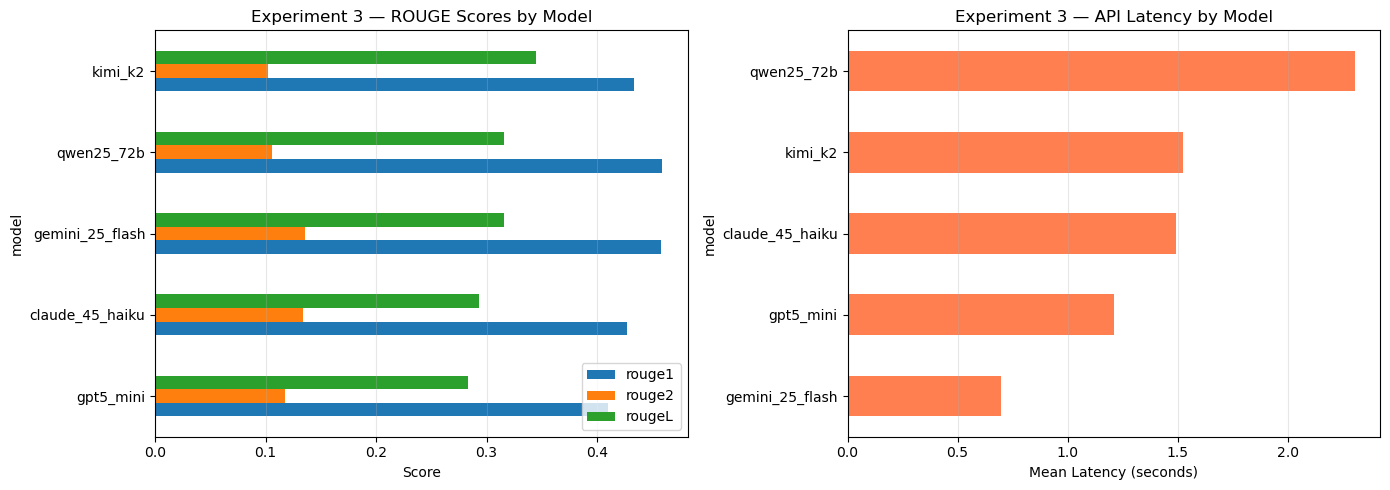

In [51]:
import matplotlib.pyplot as plt

if rouge_df is not None and len(rouge_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROUGE scores bar chart
    ax = axes[0]
    rouge_plot = rouge_df[["rouge1", "rouge2", "rougeL"]].sort_values("rougeL", ascending=True)
    rouge_plot.plot(kind="barh", ax=ax)
    ax.set_xlabel("Score")
    ax.set_title("Experiment 3 — ROUGE Scores by Model")
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3, axis="x")
    
    # Latency bar chart
    ax = axes[1]
    if latency_df is not None and len(latency_df) > 0:
        latency_plot = latency_df["mean"].sort_values(ascending=True)
        latency_plot.plot(kind="barh", ax=ax, color="coral")
        ax.set_xlabel("Mean Latency (seconds)")
        ax.set_title("Experiment 3 — API Latency by Model")
        ax.grid(True, alpha=0.3, axis="x")
    else:
        ax.text(0.5, 0.5, "No latency data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("API Latency by Model")
    
    plt.tight_layout()
    
    # Save figure
    fig_path = OUTPUT_DIR / "rouge_latency_comparison.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    print(f"Saved figure to: {fig_path}")
    
    plt.show()

else:
    print("No data to visualize.")

## 11. Test Set Qualitative Examples

Examine sample outputs from each model to understand quality beyond ROUGE scores.

In [52]:
def show_qualitative_examples(df, model_label, n=3, max_dialogue_chars=500, seed=42):
    """
    Display qualitative examples for a single model.
    
    Shows dialogue, human reference, and model prediction side by side.
    """
    # Filter out errors
    valid_df = df[~df["model_summary"].str.startswith(ERROR_PREFIX)]
    
    if len(valid_df) == 0:
        print(f"No valid examples for {model_label}")
        return
    
    # Sample examples
    sample = valid_df.sample(n=min(n, len(valid_df)), random_state=seed)
    
    print(f"\n{'='*70}")
    print(f"Qualitative Examples: {model_label}")
    print(f"{'='*70}")
    
    for i, (_, row) in enumerate(sample.iterrows(), 1):
        dialogue = row["dialogue"]
        if len(dialogue) > max_dialogue_chars:
            dialogue = dialogue[:max_dialogue_chars] + "..."
        
        print(f"\n--- Example {i} ---")
        print(f"\n[DIALOGUE]\n{dialogue}")
        print(f"\n[HUMAN SUMMARY]\n{row['reference_summary']}")
        print(f"\n[MODEL SUMMARY]\n{row['model_summary']}")
        print("-" * 50)


# Show examples for each model
for label in results_by_model:
    show_qualitative_examples(results_by_model[label], label, n=3, seed=SEED)


Qualitative Examples: gpt5_mini

--- Example 1 ---

[DIALOGUE]
Harris: How are U?
Lena: Fine, U?
Harris: Been better.
Lena: ?
Harris: My friend Aoki died yesterday.
Lena: O No!
Harris: Yeah.
Lena: What happened?
Harris: Not sure yet. Thinking the worst...
Lena: O how awful!
Harris: Yes.
Lena: You just never know.
Harris: True.
Lena: Had you seen her lately?
Harris: Not for a few months. She lives in Michigan.
Lena: Oh, that's far.
Harris: Not too far but far enough.
Lena: Right.
Harris: Got to go, mom's calling.
Lena: K bi. Feel better!
Harris: K will do

[HUMAN SUMMARY]
Harris' friend, Aoki, who lives in Michigan, died yesterday. Harris hasn't seen her for a few months.

[MODEL SUMMARY]
Harris tells Lena his friend Aoki died and he’s distraught and uncertain about the cause; Lena expresses sympathy and asks questions before Harris leaves.
--------------------------------------------------

--- Example 2 ---

[DIALOGUE]
Javier: Hey do you know any tattoo parlors over here with English

## 12. Side-by-Side Model Comparison

Compare how different models summarize the same dialogues.

In [53]:
print("\n" + "=" * 70)
print("SIDE-BY-SIDE MODEL COMPARISON")
print("=" * 70)

if len(results_by_model) < 2:
    print("Need at least 2 models for comparison.")
else:
    # Find dialogues common to all models
    dialogue_sets = {
        label: set(df["dialogue"].tolist())
        for label, df in results_by_model.items()
    }
    
    common_dialogues = set.intersection(*dialogue_sets.values())
    
    if len(common_dialogues) == 0:
        print("No common dialogues across all models.")
    else:
        print(f"Found {len(common_dialogues)} dialogues common to all {len(results_by_model)} models.")
        
        # Sample a few for comparison
        n_compare = min(3, len(common_dialogues))
        common_list = list(common_dialogues)
        
        rng = np.random.default_rng(SEED)
        sample_indices = rng.choice(len(common_list), size=n_compare, replace=False)
        sample_dialogues = [common_list[i] for i in sample_indices]
        
        # Get reference from first model's data
        first_model = list(results_by_model.keys())[0]
        first_df = results_by_model[first_model]
        
        for i, dialogue in enumerate(sample_dialogues, 1):
            ref_row = first_df[first_df["dialogue"] == dialogue].iloc[0]
            reference = ref_row["reference_summary"]
            
            print(f"\n{'='*70}")
            print(f"COMPARISON EXAMPLE {i}")
            print(f"{'='*70}")
            
            # Truncate long dialogues
            display_dialogue = dialogue[:400] + "..." if len(dialogue) > 400 else dialogue
            print(f"\n[DIALOGUE]\n{display_dialogue}")
            print(f"\n[HUMAN SUMMARY]\n{reference}")
            print(f"\n[MODEL SUMMARIES]")
            
            for label, df in results_by_model.items():
                match = df[df["dialogue"] == dialogue]
                if len(match) > 0:
                    summary = match.iloc[0]["model_summary"]
                    # Truncate long summaries
                    if len(summary) > 150:
                        summary = summary[:150] + "..."
                    print(f"  {label:20s}: {summary}")
                else:
                    print(f"  {label:20s}: [NOT FOUND]")
            
            print("-" * 70)


SIDE-BY-SIDE MODEL COMPARISON
Found 10 dialogues common to all 5 models.

COMPARISON EXAMPLE 1

[DIALOGUE]
Olafur: are we doing anything for New Year's Eve?
Nathalie: I was thinking about something classy, like opera or sth like that
Zoe: how much does it cost?
Olafur: opera is not for me
Nathalie: so what do you propose?
Nathalie: it's 100$ 
Olafur: I was thinking about partying somewhere
Nathalie: partying sounds fun, as long as it will be classy
Zoe: <file_link>
Zoe: Breakfast at Tiffany's party sou...

[HUMAN SUMMARY]
Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.

[MODEL SUMMARIES]
  gpt5_mini           : They decide to celebrate New Year's Eve in a classy way by going to a Soho club/Breakfast at Tiffany's–style party instead of the opera, and agree to ...
  gemini_25_flash     : The group decided to go to a club in Soho for New Year's Eve, after con

## 13. Error Analysis

In [54]:
print("\n" + "=" * 70)
print("ERROR ANALYSIS")
print("=" * 70)

error_summary = []

for label, df in results_by_model.items():
    total = len(df)
    errors = df["model_summary"].str.startswith(ERROR_PREFIX).sum()
    error_rate = errors / total * 100 if total > 0 else 0
    
    error_summary.append({
        "model": label,
        "total_requests": total,
        "errors": errors,
        "error_rate": f"{error_rate:.1f}%",
    })
    
    # Show sample errors
    if errors > 0:
        error_samples = df[df["model_summary"].str.startswith(ERROR_PREFIX)]["model_summary"].head(2).tolist()
        print(f"\n{label}: {errors} errors ({error_rate:.1f}%)")
        for err in error_samples:
            print(f"  - {err[:80]}...")

error_df = pd.DataFrame(error_summary)
print("\nError Summary:")
display(error_df)


ERROR ANALYSIS

Error Summary:


,model,total_requests,errors,error_rate
0,gpt5_mini,10,0,0.0%
1,gemini_25_flash,10,0,0.0%
2,claude_45_haiku,10,0,0.0%
3,qwen25_72b,10,0,0.0%
4,kimi_k2,10,0,0.0%


## 14. Save Test Results

Save final results for comparison with Experiments 1 and 2.

In [55]:
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save ROUGE summary
if rouge_df is not None:
    rouge_summary_path = OUTPUT_DIR / "rouge_summary.csv"
    rouge_df.to_csv(rouge_summary_path)
    print(f"\n✓ Saved ROUGE summary to: {rouge_summary_path}")

# Save latency summary
if latency_df is not None:
    latency_summary_path = OUTPUT_DIR / "latency_summary.csv"
    latency_df.to_csv(latency_summary_path)
    print(f"✓ Saved latency summary to: {latency_summary_path}")

# Save combined test results (for notebook 05 comparison)
if rouge_df is not None:
    test_results_data = []
    
    for model in rouge_df.index:
        row = {
            "model": model,
            "test_loss": np.nan,  # N/A for API models
            "rouge1": rouge_df.loc[model, "rouge1"] * 100,  # Convert to percentage
            "rouge2": rouge_df.loc[model, "rouge2"] * 100,
            "rougeL": rouge_df.loc[model, "rougeL"] * 100,
            "rougeLsum": rouge_df.loc[model, "rougeLsum"] * 100,
        }
        test_results_data.append(row)
    
    test_results_df = pd.DataFrame(test_results_data)
    test_results_df.to_csv(TEST_RESULTS_PATH, index=False)
    print(f"✓ Saved test results to: {TEST_RESULTS_PATH}")
    
    print("\nTest Results (for comparison with Experiments 1 & 2):")
    display(test_results_df)

# Save predictions for each model
print(f"\n✓ Predictions saved to: {PREDICTIONS_DIR}")
for label, df in results_by_model.items():
    pred_path = PREDICTIONS_DIR / f"{label}_test_predictions.csv"
    df.to_csv(pred_path, index=False)
    print(f"  - {pred_path.name}")

# Save evaluation metadata
eval_metadata = {
    "evaluation_mode": EVALUATION_MODE,
    "n_samples": len(eval_df),
    "seed": SEED,
    "models_evaluated": list(results_by_model.keys()),
    "timestamp": pd.Timestamp.now().isoformat(),
}

metadata_path = OUTPUT_DIR / "evaluation_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(eval_metadata, f, indent=2)
print(f"\n✓ Saved evaluation metadata to: {metadata_path}")


SAVING RESULTS

✓ Saved ROUGE summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/rouge_summary.csv
✓ Saved latency summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/latency_summary.csv
✓ Saved test results to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/test_results.csv

Test Results (for comparison with Experiments 1 & 2):


,model,test_loss,rouge1,rouge2,rougeL,rougeLsum
0,kimi_k2,NaN,43.313766,10.234191,34.521090,34.508377
1,qwen25_72b,NaN,45.895132,10.600222,31.584733,31.683086
2,gemini_25_flash,NaN,45.811580,13.597183,31.549697,31.665403
3,claude_45_haiku,NaN,42.733950,13.430465,29.314080,29.440342
4,gpt5_mini,NaN,40.972597,11.777140,28.347514,28.134567



✓ Predictions saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/predictions
  - gpt5_mini_test_predictions.csv
  - gemini_25_flash_test_predictions.csv
  - claude_45_haiku_test_predictions.csv
  - qwen25_72b_test_predictions.csv
  - kimi_k2_test_predictions.csv

✓ Saved evaluation metadata to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/evaluation_metadata.json


## 15. Final Summary

In [56]:
print("\n" + "=" * 70)
print("EXPERIMENT 3 — FINAL SUMMARY")
print("=" * 70)

print(f"\nEvaluation Configuration:")
print(f"  Mode: {EVALUATION_MODE}")
print(f"  Test samples: {len(eval_df)}")
print(f"  Models evaluated: {len(results_by_model)}")

print(f"\nGeneration Parameters:")
print(f"  Max output tokens: {MAX_OUTPUT_TOKENS}")
print(f"  Temperature: {TEMPERATURE}")

if rouge_df is not None and len(rouge_df) > 0:
    print(f"\nTest Set Performance (sorted by ROUGE-L):")
    
    for model in rouge_df.index:
        r1 = rouge_df.loc[model, "rouge1"] * 100
        r2 = rouge_df.loc[model, "rouge2"] * 100
        rL = rouge_df.loc[model, "rougeL"] * 100
        n = rouge_df.loc[model, "n_samples"]
        
        print(f"\n  {model}:")
        print(f"    ROUGE-1: {r1:.2f}")
        print(f"    ROUGE-2: {r2:.2f}")
        print(f"    ROUGE-L: {rL:.2f}")
        print(f"    (n={int(n)} samples)")
    
    # Best model
    best_model = rouge_df.index[0]  # Already sorted by rougeL descending
    best_rougeL = rouge_df.loc[best_model, "rougeL"] * 100
    
    print(f"\n  Best Model: {best_model} (ROUGE-L: {best_rougeL:.2f})")

if latency_df is not None and len(latency_df) > 0:
    fastest = latency_df["mean"].idxmin()
    fastest_latency = latency_df.loc[fastest, "mean"]
    print(f"\n  Fastest Model: {fastest} (mean: {fastest_latency:.2f}s)")

print(f"\nArtifacts saved to: {OUTPUT_DIR}")
print(f"  - ROUGE summary: rouge_summary.csv")
print(f"  - Latency summary: latency_summary.csv")
print(f"  - Test results: test_results.csv")
print(f"  - Predictions: predictions/")

print("\n" + "=" * 70)


EXPERIMENT 3 — FINAL SUMMARY

Evaluation Configuration:
  Mode: test
  Test samples: 10
  Models evaluated: 5

Generation Parameters:
  Max output tokens: 128
  Temperature: 0.2

Test Set Performance (sorted by ROUGE-L):

  kimi_k2:
    ROUGE-1: 43.31
    ROUGE-2: 10.23
    ROUGE-L: 34.52
    (n=10 samples)

  qwen25_72b:
    ROUGE-1: 45.90
    ROUGE-2: 10.60
    ROUGE-L: 31.58
    (n=10 samples)

  gemini_25_flash:
    ROUGE-1: 45.81
    ROUGE-2: 13.60
    ROUGE-L: 31.55
    (n=10 samples)

  claude_45_haiku:
    ROUGE-1: 42.73
    ROUGE-2: 13.43
    ROUGE-L: 29.31
    (n=10 samples)

  gpt5_mini:
    ROUGE-1: 40.97
    ROUGE-2: 11.78
    ROUGE-L: 28.35
    (n=10 samples)

  Best Model: kimi_k2 (ROUGE-L: 34.52)

  Fastest Model: gemini_25_flash (mean: 0.70s)

Artifacts saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier
  - ROUGE summary: rouge_summary.csv
  - Latency summary: latency_summary.csv
  - Test results: test_results.csv
  - Predictions: p

## 16. Key Takeaways

### Zero-Shot Performance

**Approach:**
- No training required — pure inference via API
- Single prompt design used for all models
- Temperature 0.2 for consistent, deterministic outputs

**Performance:**
- *[Fill in after running with EVALUATION_MODE = "full"]*
- Best performing model: [TBD]
- ROUGE-L range: [TBD]

### Comparison to Experiments 1 & 2

These frontier models serve as the **upper-bound baseline**:
- They have orders of magnitude more parameters
- They were trained on vastly more data
- They benefit from RLHF and instruction tuning

The comparison in notebook 05 will show:
- How close our fine-tuned models get to frontier performance
- The trade-off between local fine-tuning vs API costs
- Which fine-tuned architecture performs best relative to the gap

### Cost & Latency Considerations

**Trade-offs:**
- API models: No training cost, but per-query inference cost
- Fine-tuned models: Training cost, but free inference
- For production: Break-even point depends on query volume

**Latency:**
- *[Fill in after running]*
- Fastest model: [TBD]
- Slowest model: [TBD]

### Next Steps

- Run with `EVALUATION_MODE = "full"` for final results
- Compare all experiments in **notebook 05_evaluation_and_comparison.ipynb**